In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans

from collections import defaultdict

Loading ALdata

In [2]:
loadPath =  f'../ALdata/070906_spontaneous.csv'
df = pd.read_csv(loadPath, header = 0)

display(df['S1U1'].iloc[0])

'[17.143699999999995, 17.16379999999998, 17.170199999999994, 17.2046, 17.218799999999987, 17.2457, 17.26939999999999, 17.484399999999994, 17.496499999999997, 17.506200000000007, 17.554299999999984, 17.639199999999988, 17.6652, 17.7928, 17.817399999999992, 18.88239999999999, 18.9075, 19.221499999999992, 19.24429999999998, 19.292299999999983, 19.695999999999998, 19.703699999999998, 19.805000000000007]'

In [4]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load xlsx data, extract column with smallest pre_stim
def argMinPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMinColName = df.columns[np.argmin(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMinColName}##########")
    return argMinColName

#load csv data, extract timestamps
def loadData(mothNum):
    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/{mothNum}_spontaneous.csv'

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    # stimuli = argMinPreStim(mothNum)
    # Df = df.loc[df['stimuli'] == stimuli]
    

    tempDf = []
    tempName = []
    tempNeuron = []
    tempStimuli = []

    neuronCols = list(df.columns[3:])
    stimuli = df['stimuli'][0]
    
    for neuron in neuronCols:
        curArr,nameArr = readData(df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr
        tempNeuron += [neuron] * len(curArr)
        tempStimuli += [stimuli] * len(curArr)

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    # print(tempName)

    return tempDf,tempName,tempNeuron,tempStimuli

In [5]:
display(len(loadData('070906')[3]))

12

Derive Nine Parameters

In [6]:
#from timestamp data count average spike frequency (spike count/duration)
def countSpikingFreq(timestamps):
    sum_duration = 0
    spike_count = 0
    for timestamp in timestamps:
        sum_duration += timestamp[-1] - timestamp[0]
        spike_count += len(timestamp)
    return spike_count/sum_duration

#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]

#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    totalNeuron = []
    totalStimuli = []
    for mothName in mothNames:
        mothDf,mothNameArr,mothNeuronArr,mothStimuliArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
        totalNeuron += mothNeuronArr
        totalStimuli += mothStimuliArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName,totalNeuron,totalStimuli

def formulateDataset(totalDf,totalName = None,totalNeuron = None,totalStimuli = None):
    sampleDataset = []
    nameRes = []
    neuronRes = []
    stimuliRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_neuronRes = []
    no_burst_stimuliRes = []


    if totalName is None:
        totalName = ['']*(len(totalDf))

    
    if totalNeuron is None:
        totalNeuron = ['']*(len(totalDf))
    
    if totalStimuli is None:
        totalStimuli = ['']*(len(totalDf))
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            neuronRes.append(totalNeuron[index])
            stimuliRes.append(totalStimuli[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_neuronRes.append(totalNeuron[index])
            no_burst_stimuliRes.append(totalStimuli[index])

    return sampleDataset,nameRes,neuronRes,stimuliRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes



In [7]:
#GIT data for unsupervised learning
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName,totalNeuron,totalStimuli = collectModelData(mothNames)



########current number of rows: 12########
########current number of rows: 7########
########current number of rows: 14########
########current number of rows: 15########
########current number of rows: 16########
########current number of rows: 15########
########current number of rows: 14########
############all data loaded############
############totalDf row number93############


10.722159044042394

Text(0.5, 1.0, 'spiking frequency of each sample')

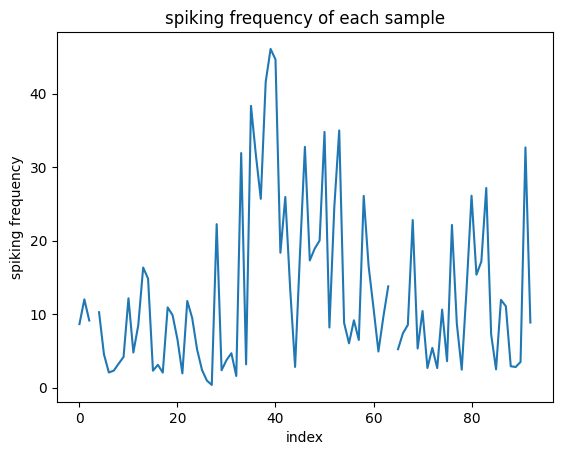

In [8]:
display(countSpikingFreq(totalDf))

# for index in range(len(totalDf)):
#     print(index)
#     print(countSpikingFreq([totalDf[index]]))

#plot index,spiking frequency
spikingFreq = []
for index in range(len(totalDf)):
    spikingFreq.append(countSpikingFreq([totalDf[index]]))

plt.plot(spikingFreq)
plt.xlabel('index')
plt.ylabel('spiking frequency')
plt.title('spiking frequency of each sample')

In [10]:
x_bot = np.linspace(0, 200, 2000000)
fig, axs = plt.subplots(23,figsize=(50, 500))
for i in range(23):
    index = 20*i
    arr = totalDf[index]
    y = []
    for x in x_bot:
        #round to the fourth digit
        x = round(x,4)
        if x in arr:
            y.append(1)
        else:
            y.append(0)
    #add subplot
    axs[i].plot(x_bot,y)
    #set x y label
    axs[i].set_xlabel('time')
    axs[i].set_ylabel('spike')

    #set subplot title
    axs[i].set_title(f"spike train of {totalName[index]}_{totalNeuron[index]}_{totalStimuli[index]}")

    # #set main title
    # plt.suptitle("spike train of all neurons")
plt.show()
fig.savefig('unlabled_data_spikes.pdf')

In [9]:
display(totalDf[:10])

[array([17.1437, 17.1638, 17.1702, 17.2046, 17.2188, 17.2457, 17.2694,
        17.4844, 17.4965, 17.5062, 17.5543, 17.6392, 17.6652, 17.7928,
        17.8174, 18.8824, 18.9075, 19.2215, 19.2443, 19.2923, 19.696 ,
        19.7037, 19.805 ]),
 array([16.0076, 16.0728, 16.0798, 16.1174, 16.1687, 16.1875, 16.2199,
        16.2785, 16.4193, 16.4347, 16.5062, 16.5185, 16.5305, 16.5346,
        16.5529, 16.7391, 17.0222, 17.0859, 17.1523, 17.2681, 17.2783,
        17.3007, 17.304 , 17.3215, 17.3702, 17.4234, 17.4406, 17.5147,
        17.5316, 17.5449, 17.6216, 17.6361, 17.6947, 17.752 , 17.7748,
        17.7995, 17.8075, 17.9003, 18.701 , 18.7601, 18.8643, 18.9433,
        19.3699, 19.6723]),
 array([19.4153, 19.6343]),
 array([19.4293]),
 array([16.0835, 16.1781, 16.1951, 16.4575, 16.6217, 16.6641, 17.0181,
        17.0251, 17.1247, 17.1419, 17.1899, 17.2221, 17.2852, 17.5057,
        17.6412, 17.6589, 17.6781, 17.8487, 17.8693, 17.9497, 18.1114,
        18.2192, 18.458 , 18.5024, 18.5323, 1

In [18]:
#not run if sampleDataset.pkl already exists
#formulate dataset
sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes \
         = formulateDataset(totalDf,totalName,totalNeuron,totalStimuli)

#save sampleDataset
with open('unsupervised_learning/spontaneous_sampleDataset.pkl', 'wb') as f:
    pickle.dump((sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes), f)

In [19]:
#get row of DF with lowest difference between first and last timestamp
def getMinDiffRow(df):
    minDiff = math.inf
    minInd = -1
    for ind in df.index:
        curDiff = df.iloc[ind][-1] - df.iloc[ind][0]
        if curDiff < minDiff:
            minDiff = curDiff
            minInd = ind
    return minInd

In [20]:
with open('unsupervised_learning/sampleDataset.pkl', 'rb') as f:
    sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes = pickle.load(f)
    

print(stimuliRes)

['Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr', 'Myr']


In [21]:
print(np.array(sampleDataset).shape)

print(len(no_burst_sampleDataset))

(88, 9)
5


In [22]:
#unsupervised --- check whether a (moth,neuron) pair either has burst or hasn't burst regardless of stimuli
droppedDF = pd.DataFrame({'mothName':no_burst_nameRes,\
                          'neuron':no_burst_neuronRes,\
                            'stimuli':no_burst_stimuliRes})

print(droppedDF.shape)

(5, 3)


In [23]:
#unsupervised -- save data into csv file
def saveData(Dataset,nameRes,neuronRes,stimuliRes):
    #load data from csv file
    savePath =  'unsupervised_learning/nine_parameters.csv'

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['Neuron'] = neuronRes
    df['Stimuli'] = stimuliRes
    
    df.to_csv(savePath, index=False)
    return df

df = saveData(sampleDataset,nameRes,neuronRes,stimuliRes)

In [17]:
display(df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli
0,2.5354,8.677132,21.568325,22,0.0246,1.000000,0.100985,8.510000,13.005666,070906,S1U1,Lin
1,2.7639,14.834111,20.556698,41,0.0928,0.953488,0.101666,11.922123,22.067839,070906,S2U1,Lin
2,3.7055,10.524895,10.524895,39,0.0000,1.000000,0.050041,15.146894,15.146894,070906,S2U4,Lin
3,3.0363,4.281527,93.750000,13,0.0428,1.000000,0.154292,6.023302,7.575765,070906,S2U5,Lin
4,2.2577,2.214643,2.214643,5,0.0000,1.000000,0.050921,2.997372,2.997372,070906,S3U1,Lin
...,...,...,...,...,...,...,...,...,...,...,...,...
83,14.7142,3.058270,12.318305,45,3.4591,0.865385,0.251192,3.445576,8.179410,071002,S1U1_selectiveunit,Myr
84,3.7474,8.005551,70.422535,30,13.9318,0.600000,0.357411,2.188973,3.521100,071002,S1U2,Myr
85,5.6985,8.949724,20.990764,51,12.9673,0.784615,0.250262,3.815550,9.769924,071002,S1U3,Myr
86,5.5851,87.196290,130.434783,487,13.2511,0.789303,2.100137,2.918520,18.424534,071002,S1U4,Myr


In [6]:
def reductionClustering(sampleDF,reducedColumnNames,\
                        tailColumnNames,reductionFunc,\
                            reductionParams,clusteringFunc,\
                                clusteringParams,shuffleRandomState,\
                                    isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF.loc[:,reducedColumnNames])

    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #normalization again
    #reducedSample = preprocessing.normalize(reducedSample)

    #KMeans classification
    clusteringModel = clusteringFunc(**clusteringParams)

    #fit clustering model
    clusteringModel.fit(reducedSample)


    #put last columns back to reducedSample and form new dataframe
    reducedSample = np.hstack((reducedSample,sampleDF.loc[:,tailColumnNames].to_numpy()))
    reducedSampleDF = pd.DataFrame(reducedSample,columns = ['PC1','PC2']+tailColumnNames)
    
    #add label to sample dataframes
    reducedSampleDF['pred_label'] = copy.deepcopy(clusteringModel.labels_)
    sampleDF['pred_label'] = copy.deepcopy(clusteringModel.labels_)
    

    return sampleDF,reducedSampleDF


#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#KMeans
KMeansParams = {'n_clusters':3,'random_state':42}

In [11]:
#Result
#unsupervised
reducedColumnNames = list(df.columns[:-3])
tailColumnNames = list(df.columns[-3:])
DF,reducedSampleDF = reductionClustering(df,reducedColumnNames,tailColumnNames,\
                                         KernelPCA,KPCAparams,\
                                            KMeans,KMeansParams,42,isShuffle = True)

Statistics Result Analysis

In [21]:
#extract numpy array from dataframe df with designated columns and subject default = 070921
#neglect the last two columns (subject and stimuli)
def extractNumpyArray(DF,lstColumnNames,subject):
    extractedDF = DF.loc[DF['Subject'] == subject]
    extractedDF = extractedDF.loc[:,lstColumnNames]
    return extractedDF


def classificationResultPlot(reducedSampleDF,lstColumnNames = ['PC1','PC2','pred_label'] ,subject = '070921',save_name = 'kmeans_2.png'):
    #plotting according to kmeans clustering classification result
    fig = plt.figure(figsize=(15,15))

    fig.add_subplot(2,1,1)
    sns.scatterplot(x='PC1',y='PC2',hue='pred_label',data=reducedSampleDF).set_title('KMeans Classification Result')

    #plot according to subject
    if subject != None:
        #extract reducedSampleDF
        extractedReducedSampleDF = extractNumpyArray(reducedSampleDF,lstColumnNames,subject)
        
        fig.add_subplot(2,1,2)

        sns.scatterplot(x='PC1',y='PC2',hue='pred_label',data=extractedReducedSampleDF).set_title(f'KMeans Classification Result for {subject}')
        #plt.legend()
    
    plt.show()

    #save figures
    fig.savefig(save_name)

    return

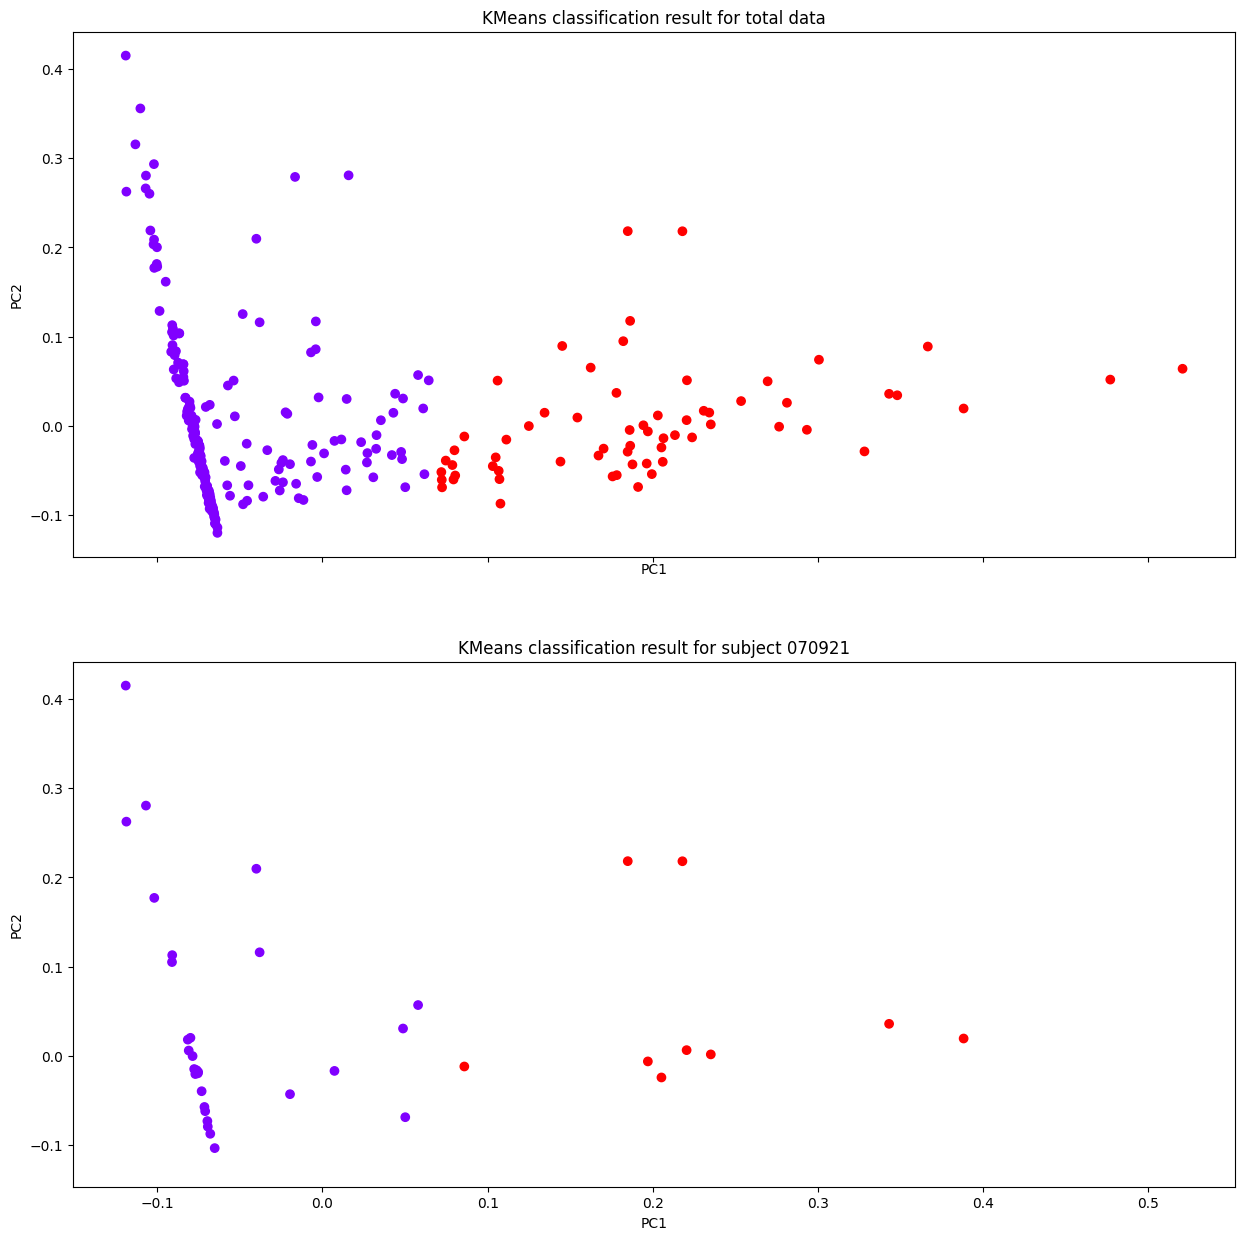

In [13]:
classificationResultPlot(reducedSampleDF)

In [8]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('pred_label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

#print(numberDatapointsInClusters(DF))

In [9]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'unsupervised_learning/histograms.jpg',barplot = False):
    #3x3 subplots
    #fig,ax = plt.subplots(9,1,figsize=(15,15))
    fig = plt.figure(figsize=(15,15))
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        #use "y = " for barplot, "x = " otherwise
        #figure into the jth subplot
        if barplot:
            fig.add_subplot(3,3,j+1)
            plotFunc(data=DF,y=lstColumnNames[j],**plotParams)
        else:
            fig.add_subplot(3,3,j+1)
            plotFunc(data=DF,x=lstColumnNames[j],**plotParams)

        #ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

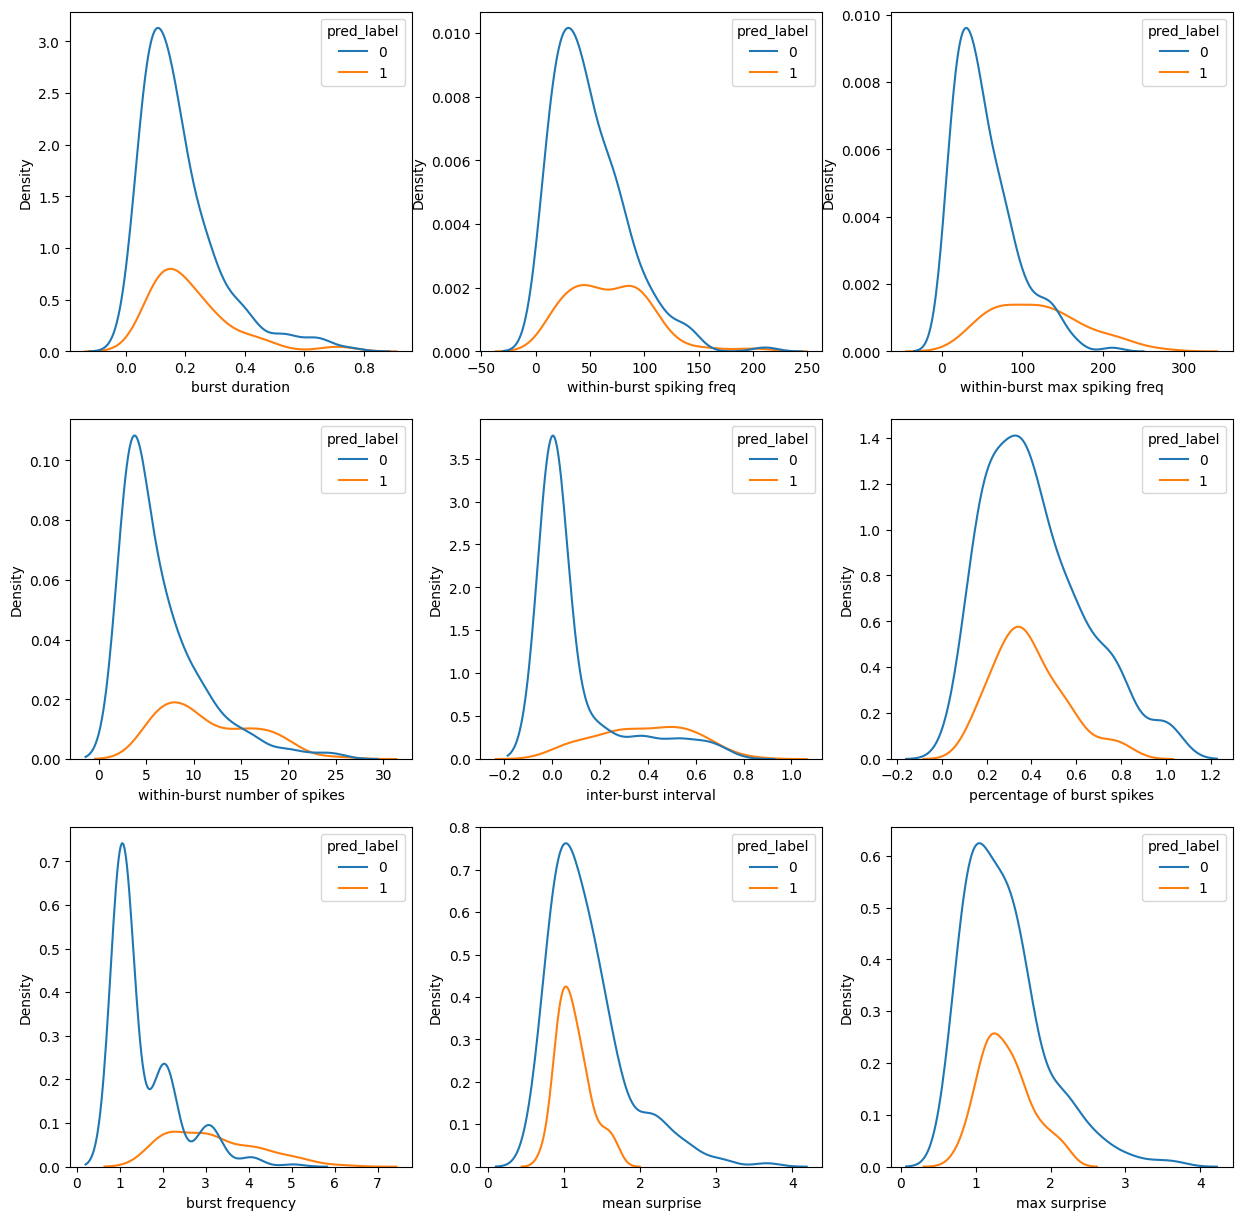

In [16]:
histoResults(DF,reducedColumnNames,sns.kdeplot,{'hue':'pred_label'},'unsupervised_learning/kdeplot.jpg')

In [10]:
#concatenate 50 random samples from df1 and df2 
def concatRandomSamples(DF,numSamples,N = 2,randomState = 42,label = 'pred_label'):
    #split dataframe by labels
    lstLabels = range(N)
    lstDF = ['']*len(lstLabels)
    for i in lstLabels:
        elementDF = DF.loc[DF[label] == i]
        #print(elementDF.shape)
        #randomly select 50 samples from each dataframe
        elementDF = elementDF.sample(n=numSamples,random_state = randomState)

        lstDF[i] = elementDF


    #concatenate dataframes
    df = pd.concat(lstDF,axis=0)
    return df


In [18]:
concatDF = concatRandomSamples(DF,50)
print(concatDF)

     burst duration  within-burst spiking freq  within-burst max spiking freq  \
231          0.2523                  19.817677                      19.817677   
2            0.2256                  17.730496                      17.730496   
20           0.1936                  36.157025                      36.157025   
106          0.1621                  43.183220                      43.183220   
33           0.1419                  21.141649                      21.141649   
..              ...                        ...                            ...   
75           0.4079                  46.580044                     111.940299   
255          0.2780                  21.582734                      31.948882   
42           0.2989                  33.456005                      89.820359   
71           0.0964                 114.107884                     152.439024   
40           0.6926                  21.657522                      40.691760   

     within-burst number of

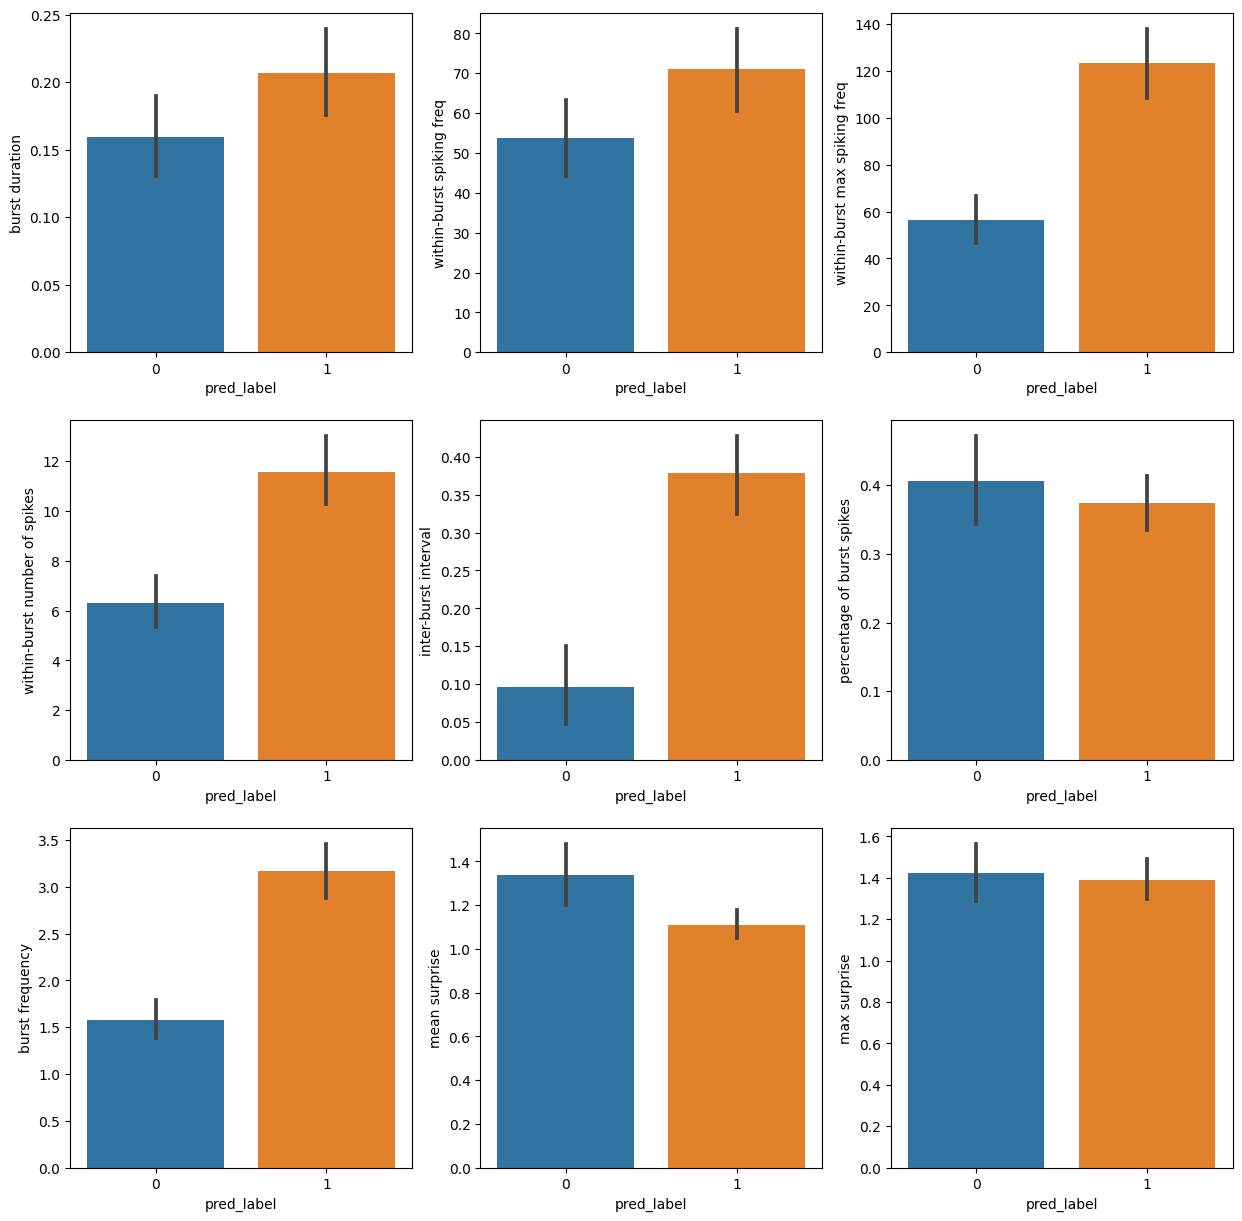

In [19]:
histoResults(concatDF,reducedColumnNames,\
                        sns.barplot,{'x':'pred_label'},'unsupervised_learning/barplot_50.jpg',barplot = True)

Read labeled data

In [4]:
#load nine_burst_parameters.csv from supervised learning directory
loadPath =  '~/Documents/GitHub/AL_generative/labeled_data/nine_burst_parameters.csv'

labeled_df = pd.read_csv(loadPath, header = 0)

In [5]:
display(labeled_df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.40261,12.418966,12.418966,5,0.00000,0.217391,0.201957,1.192730,1.192730,60324124,0
1,0.26911,59.455241,59.455241,16,0.00000,0.092486,0.200605,1.257588,1.257588,71031002,0
2,0.02979,100.704935,100.704935,3,0.00000,0.010563,0.200198,3.615758,3.615758,71031005,0
3,1.64504,20.668190,41.447914,34,1.60726,0.566667,1.409171,1.000481,1.586471,70928019,1
4,2.68866,14.877299,35.663338,40,1.71490,0.833333,1.423734,1.734164,3.247514,70928018,1
...,...,...,...,...,...,...,...,...,...,...,...
96,1.41775,28.213719,46.082949,40,2.05415,0.588235,1.438033,1.686918,3.619528,704004080,2
97,1.05797,27.410985,48.971596,29,2.19926,0.527273,1.235203,1.437265,2.151369,704004058,2
98,1.41001,28.368593,70.530152,40,3.48801,0.597015,1.625478,1.543561,2.553736,704004059,2
99,0.89093,24.693298,51.809637,22,1.41134,0.366667,1.025910,1.577922,2.530512,704004060,2


In [7]:
labeled_reducedColumnNames = list(labeled_df.columns[:-2])
labeled_tailColumnNames = list(labeled_df.columns[-2:])
labeled_DF,labeled_reducedSampleDF = \
    reductionClustering(labeled_df,labeled_reducedColumnNames,\
                         labeled_tailColumnNames,\
                        KernelPCA,KPCAparams,\
                            KMeans,KMeansParams,42,isShuffle = True)

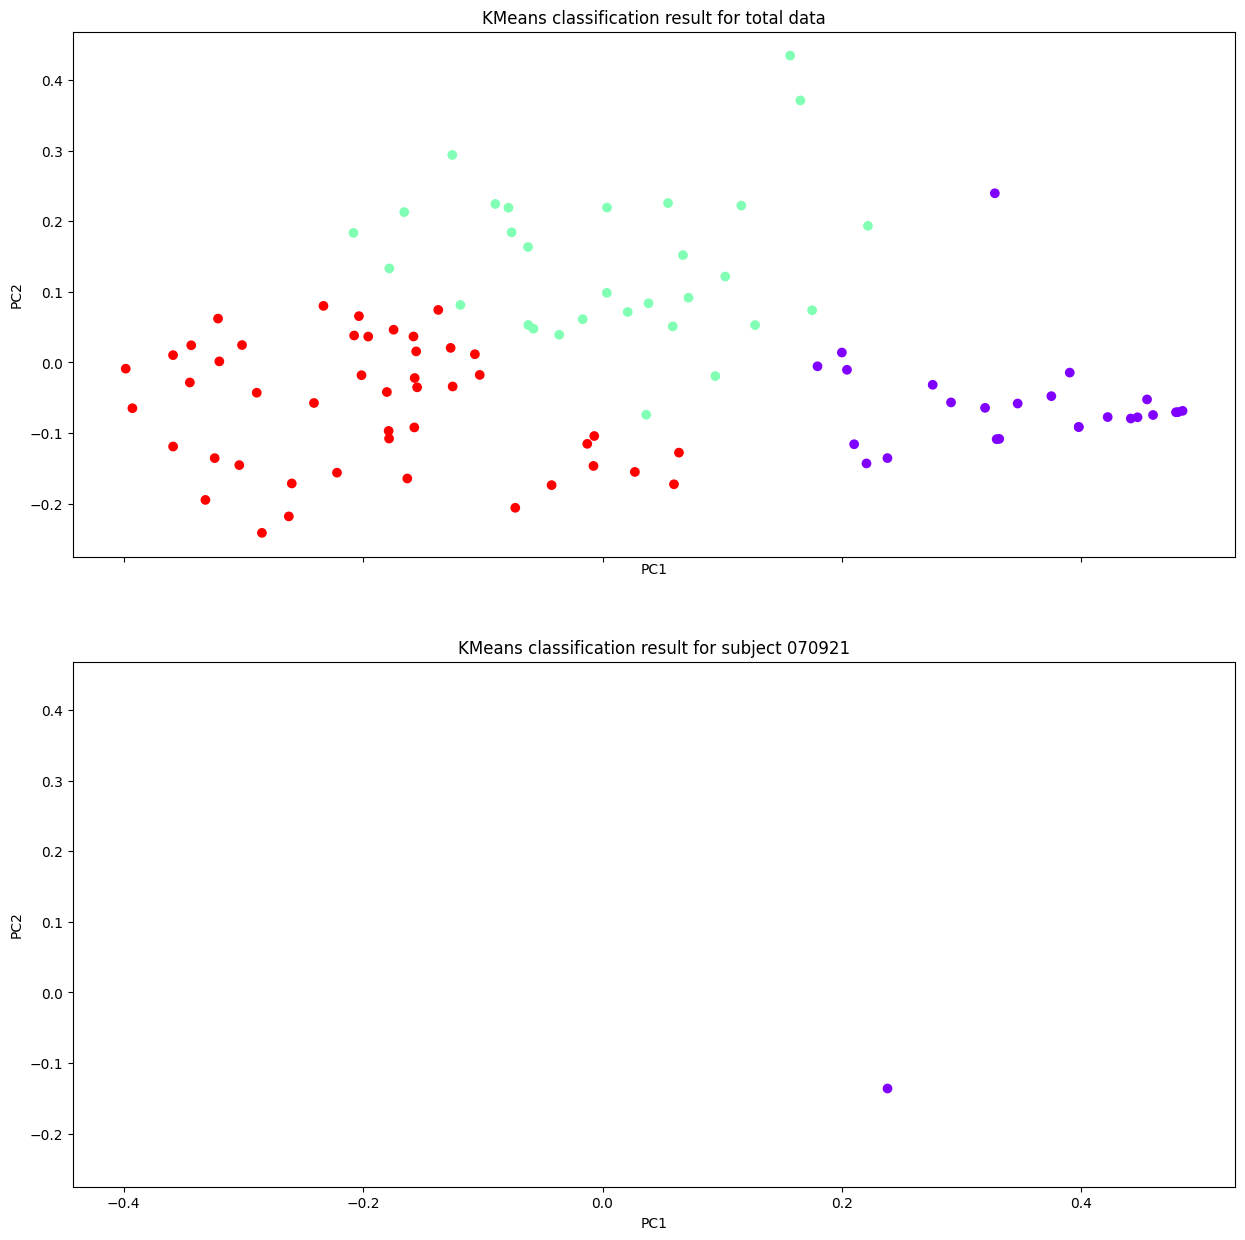

In [10]:
classificationResultPlot(labeled_reducedSampleDF,subject=60324124)

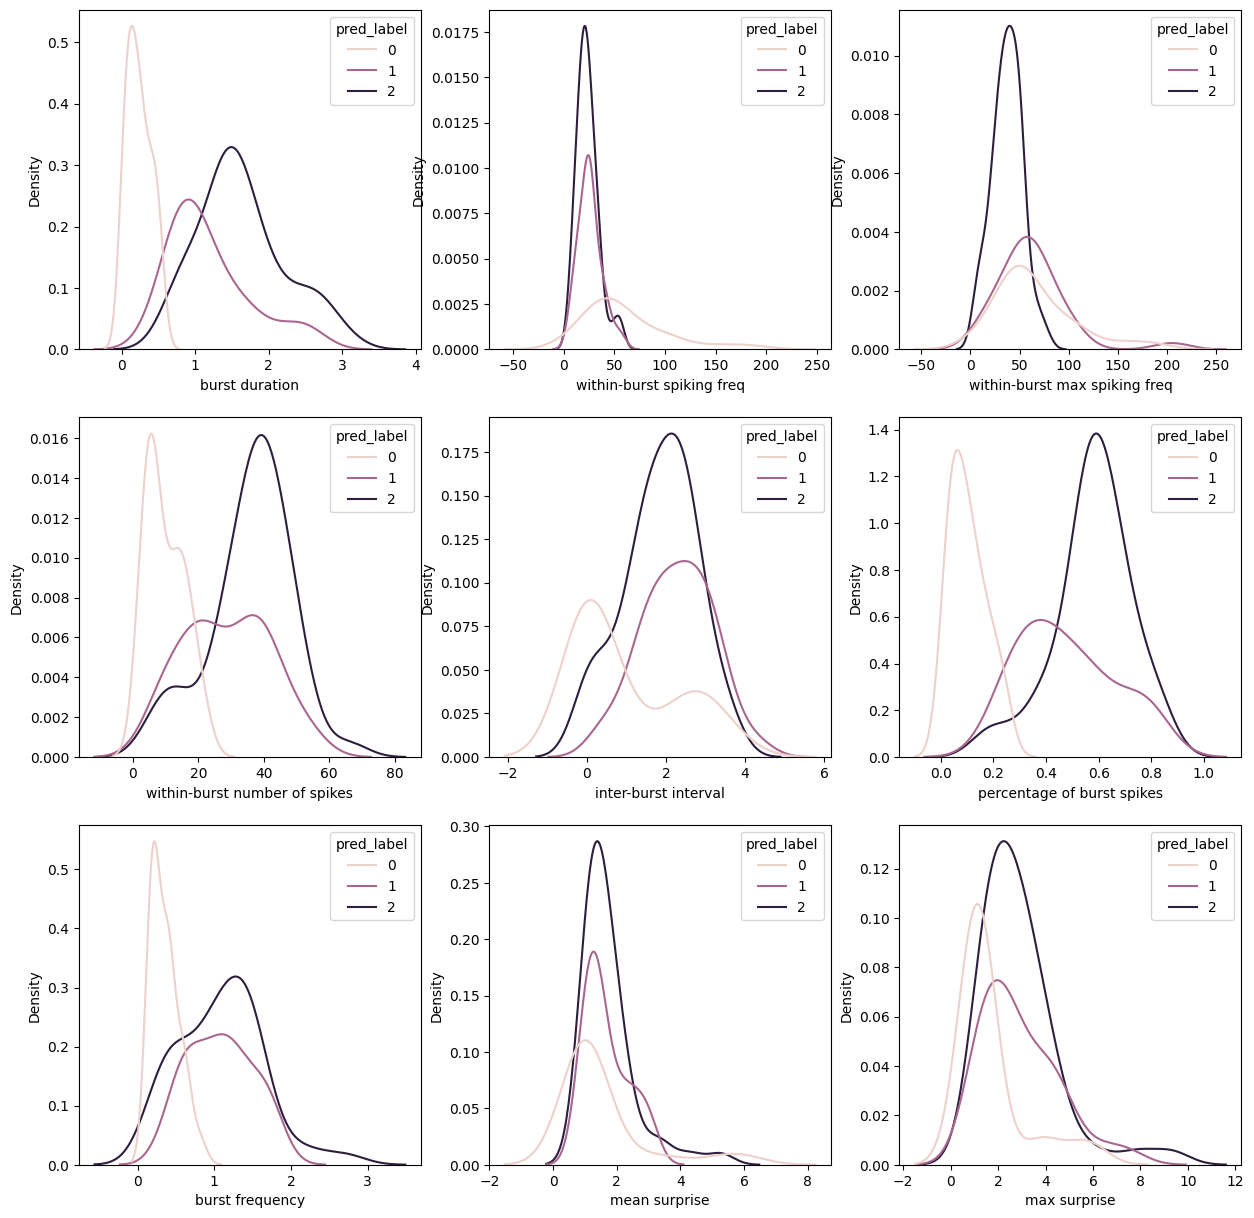

In [11]:
#kdeplot
histoResults(labeled_DF,labeled_reducedColumnNames,sns.kdeplot,{'hue':'pred_label'},'unsupervised_learning/labeled_kdeplot.jpg')

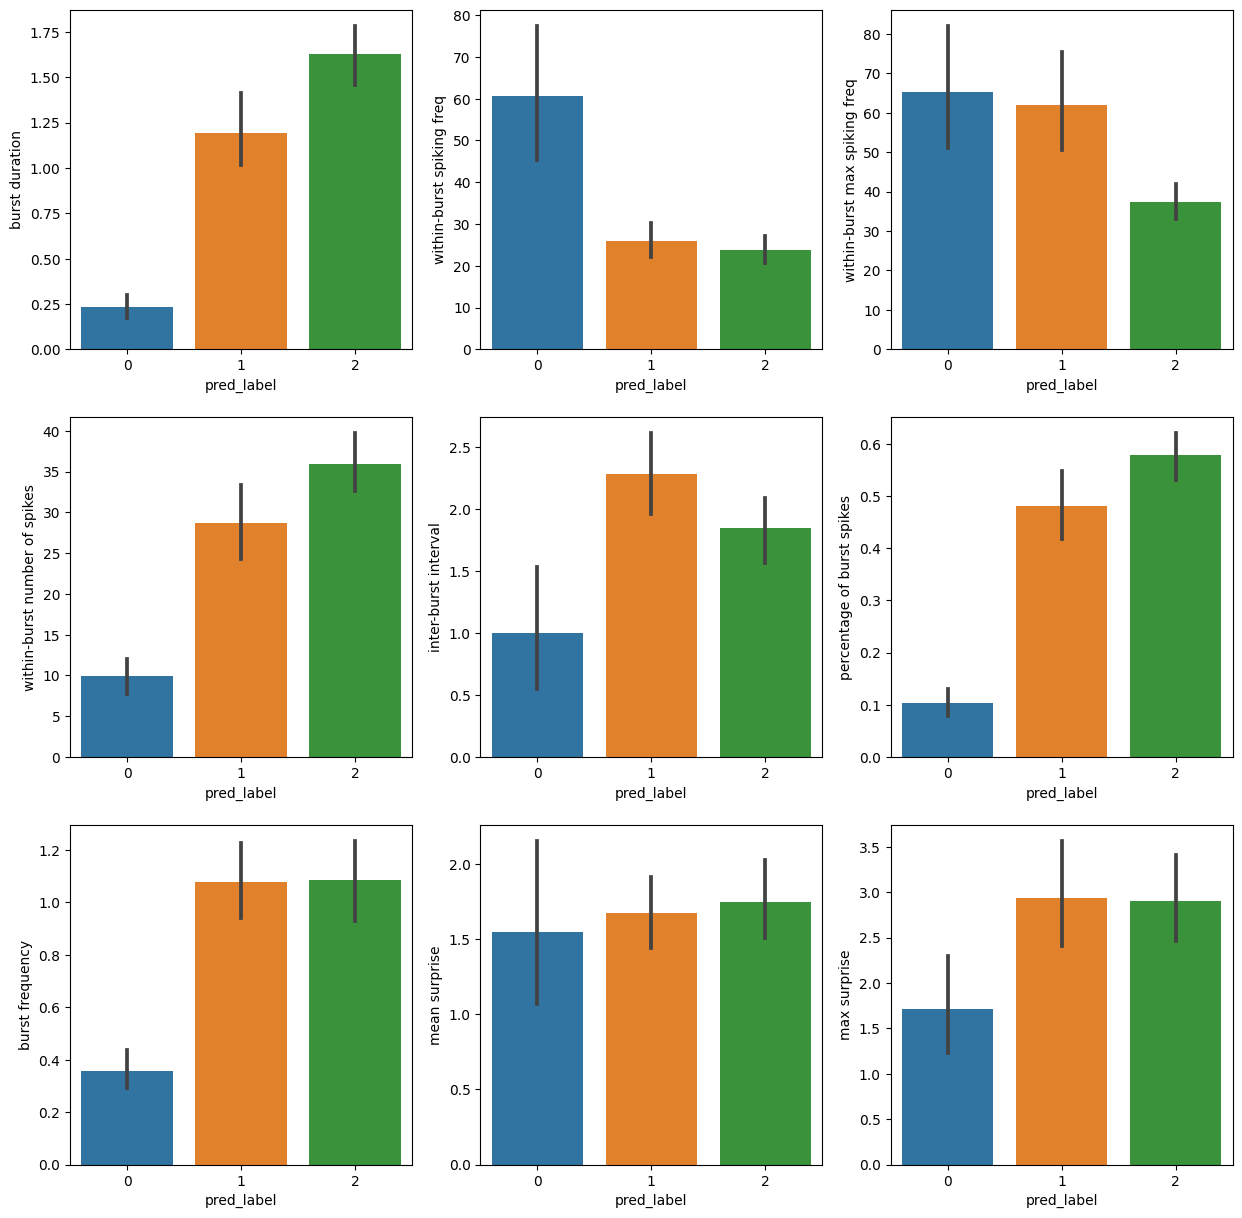

In [12]:
#histogram
histoResults(labeled_DF,labeled_reducedColumnNames,\
                        sns.barplot,{'x':'pred_label'},'unsupervised_learning/labeled_barplot.jpg',barplot = True)

Unsupervised Learning for LN_and_PN data

In [14]:
#load nine_parameters_df
LNandPN_nine_parameters_df = pd.read_csv('LNandPN_nine_burst_parameters.csv')

In [16]:
display(LNandPN_nine_parameters_df)

#label value count
print(LNandPN_nine_parameters_df['label'].value_counts())

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.024163,1655.403029,7455.268390,40,0.035349,0.869565,77.376623,3.785197,6.606620,ts_LN_CR020108A,0
1,0.006714,9532.391513,12096.774194,64,0.023597,0.477612,113.147771,3.330612,8.910360,ts_LN_CR020115A,0
2,0.063776,752.628319,2355.157796,48,0.078496,0.727273,62.486982,2.000355,4.948261,ts_LN_CR020208A,0
3,0.088818,720.574658,15406.162465,64,0.011019,0.941176,109.235353,4.558693,12.350901,ts_LN_CR020221A,0
4,0.066259,1131.921701,4479.840717,75,0.001570,1.000000,113.104579,3.160761,7.586543,ts_LN_CR020225B,0
...,...,...,...,...,...,...,...,...,...,...,...
60,0.029699,3131.471286,20833.333333,93,0.010481,0.930000,171.144960,8.138343,24.376297,ts_PN_CR040723A,1
61,0.014148,15478.946159,75685.903500,219,0.000777,0.943966,601.202405,5.027307,8.595686,ts_PN_CR040914A,1
62,0.030141,5076.125291,10522.623641,153,0.010289,0.987097,121.820485,11.618986,24.205032,ts_PN_CR040916A,1
63,0.011717,8961.185266,15118.427684,105,0.000078,0.981308,134.039274,6.169706,9.239340,ts_PN_CR040920A,1


1    48
0    17
Name: label, dtype: int64


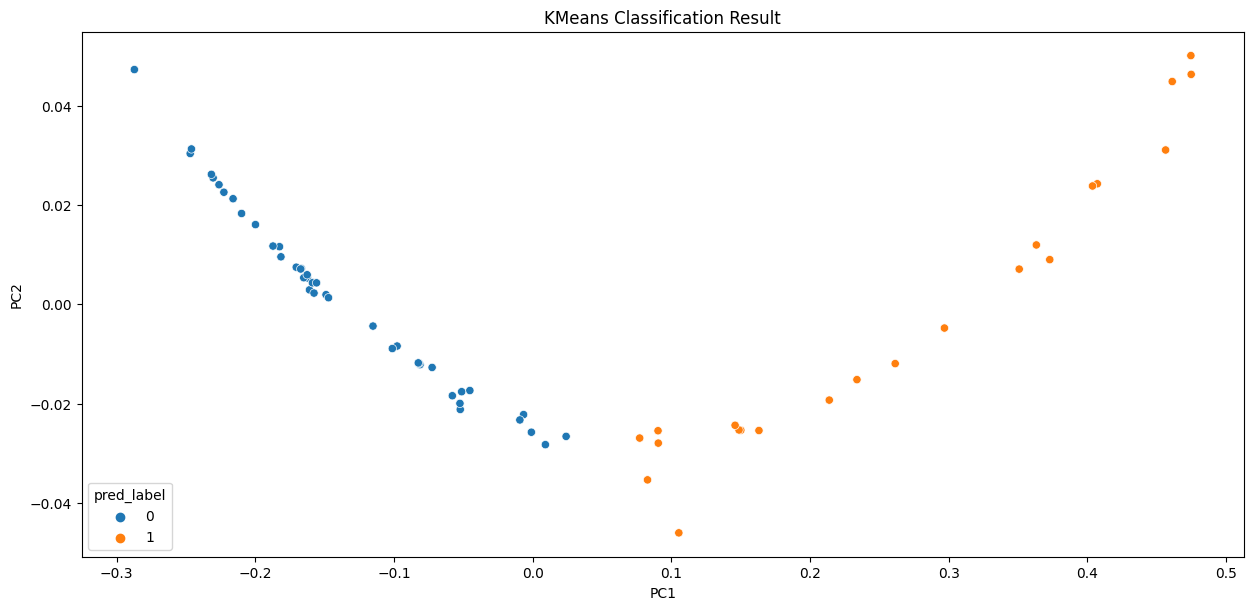

In [23]:
LNandPN_lstColumnNames = list(LNandPN_nine_parameters_df.columns[:-2])

#unsupervised

#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#KMeans
KMeansParams = {'n_clusters':2,'random_state':42}

#Result
#unsupervised
LNandPN_tailColumnNames = list(LNandPN_nine_parameters_df.columns[-2:])
LNandPN_KMeansClustering_DF,\
   LNandPN_KMeansClustering_reducedSampleDF = \
      reductionClustering(LNandPN_nine_parameters_df,\
         LNandPN_lstColumnNames,\
            LNandPN_tailColumnNames,\
               KernelPCA,KPCAparams,\
                  KMeans,KMeansParams,42,isShuffle = True)

classificationResultPlot(LNandPN_KMeansClustering_reducedSampleDF,\
                         subject=None,\
                         save_name='LNandPN_kmeans_2.jpg')

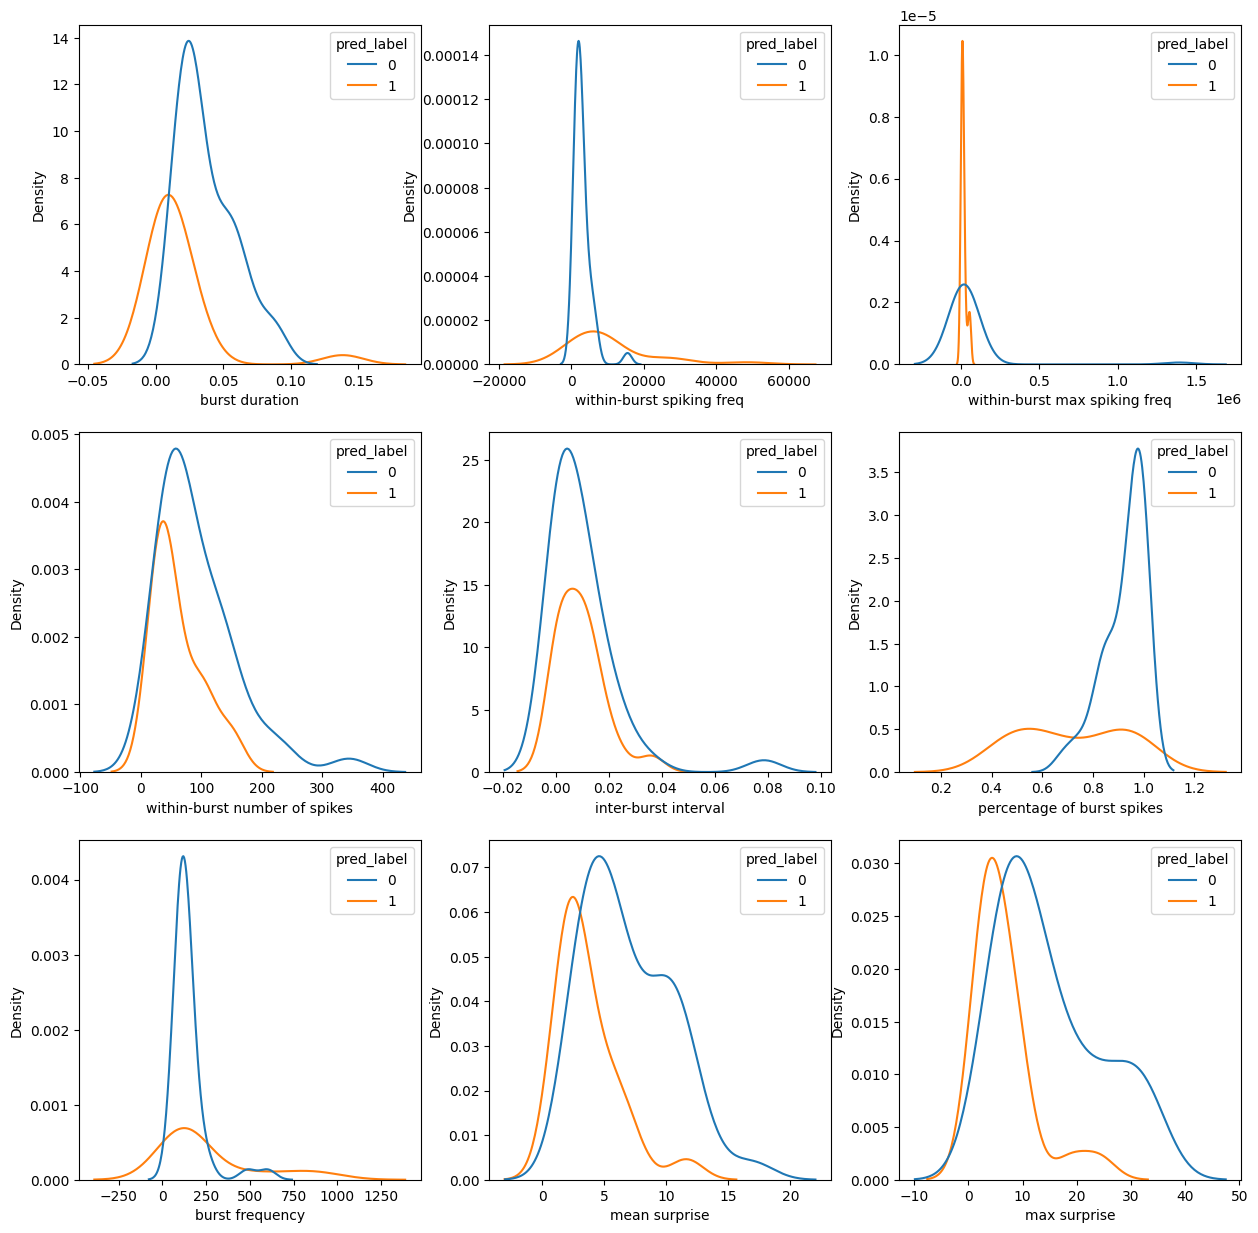

In [24]:
#kdeplot
histoResults(LNandPN_KMeansClustering_DF,LNandPN_lstColumnNames,\
             sns.kdeplot,{'hue':'pred_label'},\
                 'unsupervised_LNandPN_kdeplot.jpg')

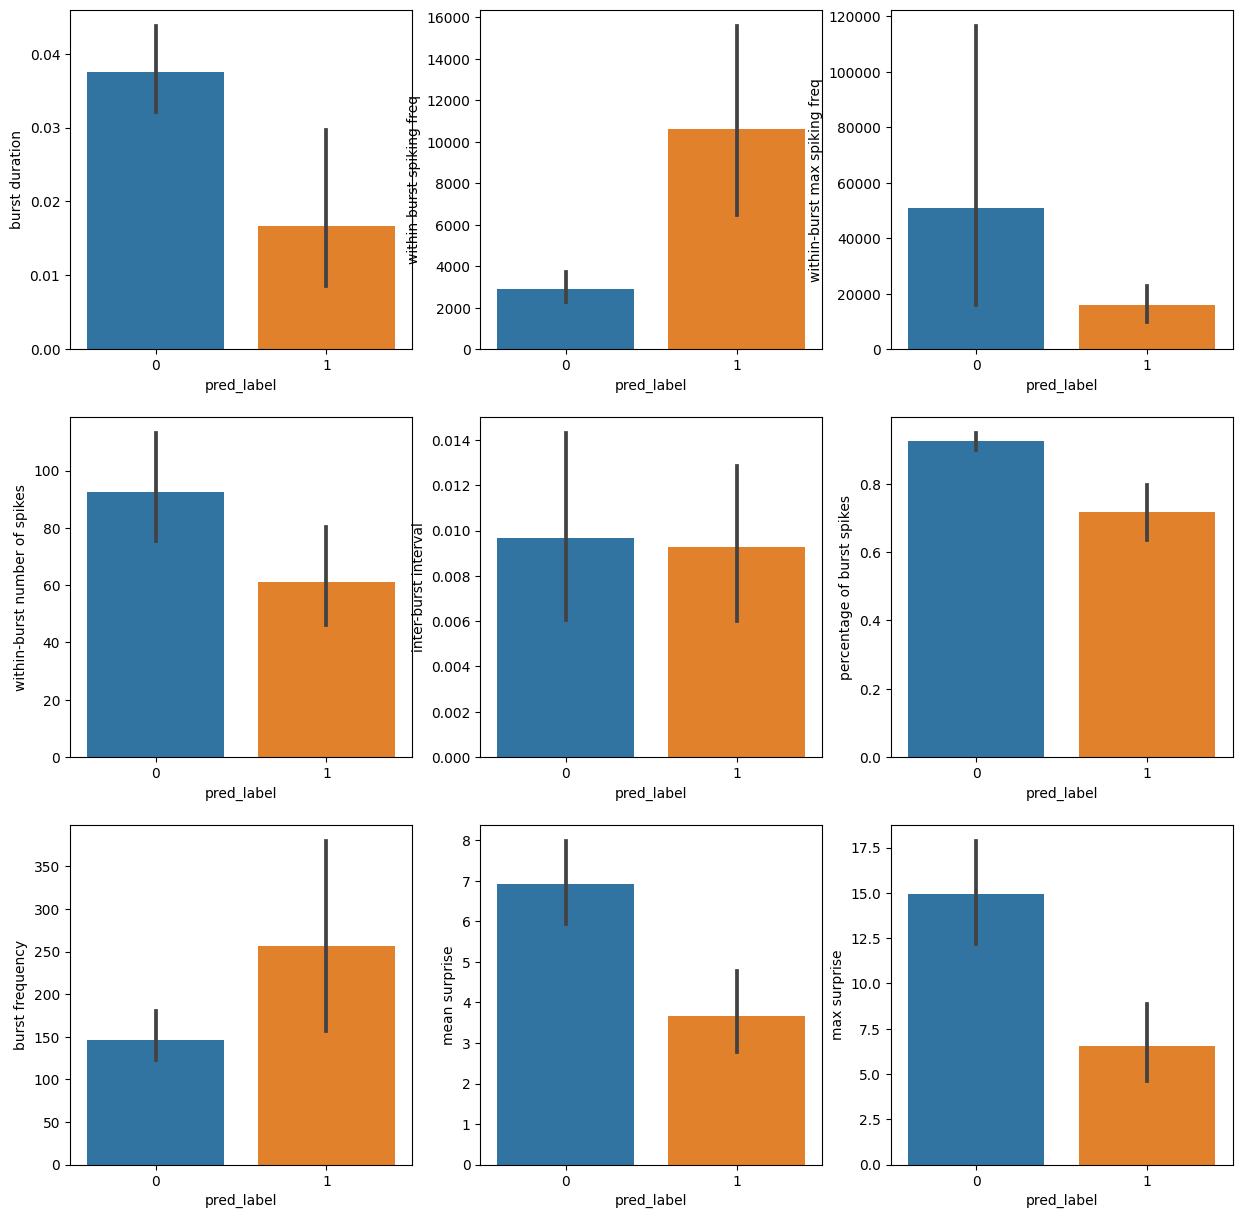

In [25]:
#barplot
histoResults(LNandPN_KMeansClustering_DF,LNandPN_lstColumnNames,\
             sns.barplot,{'x':'pred_label'},\
                 'unsupervised_LNandPN_barplot.jpg',barplot = True)